<h1><u><center> Economic Scenario Generator Project - Projet DDEFI </center></u></h1>
<img src = "https://www.econostrum.info/photo/art/grande/36648656-32651177.jpg?v=1566465679" 
     title = "NASDAQ Logo" alt = "Nasdaq Logo" width="300">

<h3><center> Anaïs Auzanneau / Alison Cortesi / Germain Lefebvre / Florent Morin / Vincent Bilger</center></h3>

<h4><center> - </h4></center>
<h4><center> École Centrale Marseille </h4></center>

### Sommaire  <a class="anchor" id="sommaire"></a>

[Préliminaire - État de l'art](#Etat_Art)

* [0 - Importation des ressources](#chapter0)
    * [Important : Définition de la classe "Series"](#chapter0.important)


* [I - Préparation de notre data set pour la simulation](#chapter1)
    * [I.1 - Conversion des données en rendements logarithmiques](#chapter1.1)
    * [Complément : Modélisation d'une portefeuille d'actions pondéré](#chapter1.complement)
    * [I.2 - Split de notre data set](#chapter1.2)
    
    
* [II - Modélisation paramétrique](#chapter2)
    * [II.1  Modèle GARCH(p,q)](#chapter2.section1)
    * [II.2 - Simulations grâce à notre modèle GARCH(p,q)](#chapter2.section2)

        
* [III- Bootstrapping](#chapter3)


* [IV - Filtred Historical Simulation ](#chapter4)


* [V - Fonction de performance](#chapter5) 
    * [V.1 - Fonctions de mesures](#chapter5.section1)
    * [V.2 - Fonction Describe](#chapter5.section2)
    * [V.3 - Comparaison des prévisions par boostrapping, par FHS et GARCH(p,q)](#chapter5.section3)




## Prélimianires - État de l'art <a class="anchor" id="Etat_Art"></a>

{Insert Etat de l'art sur les documents fourni}

## 0 - Importation des ressources <a class="anchor" id="chapter0"></a>

In [1]:
# conda install -c saravji pmdarima
# conda install -c conda-forge statsmodels

import pandas as pd                                       #Used in all section
import numpy as np                                        #Used in all section
from math import *                                        #Used in all section
import datetime                                           #Used in section 0
from datetime import date                                  #Used in section 0
from statsmodels.tsa.arima_model import ARIMA             #Used in section 3.1.1
import warnings
import time
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import pmdarima as pm                                     #Used in section 3.1.1              
#from pmdarima.arima import ARIMA                          #Used in section 3.1.1
from statsmodels.graphics.tsaplots import plot_acf        #Used in section 3.1.2 et 3.1.3
from arch import arch_model                               #Used in section 3.1.2 et 3.1.3
import random                                             #Used in section 4 and 5
import matplotlib.pyplot as plt                           #Used in all section
import plotly.graph_objects as go                         #Used in section 4.3
plt.style.use('ggplot')
from statsmodels.stats.weightstats import ztest           #Used in section 6.1
from scipy import stats                                   #Used in section 6.1
from scipy.stats import f_oneway                          #Used in section 6.1 
from scipy.stats import mannwhitneyu                      #Used in section 6.1
from scipy.stats import wasserstein_distance              #Used in section 6.1
from scipy.stats import wilcoxon                          #Used in section 6.1 

$! Attention !$ Ne pas oublier de changer le chemin ci-dessous en fonction de l'utilisateur afin d'arriver au fichier contenant les bases de données.

In [2]:
# root_path = 'C:/Users/anais/Documents/Centrale/Cours/3A/DDEFi/Projet DDEFi/Ressources/Data/'      #Anais
root_path = 'C:/Users/33649/Desktop/A3/Projet DDEFI/BP2S/Code_Data_2020/BDD/'                         #Germain
#root_path = 'C:/Users/flomo/Desktop/Projet BNP/Data/'                                             #Florent
# root_path = 'C:/Users/Vincent/Desktop/PROJET DDEFI/DATA/'                                         #Vincent
# root_path = 'C:/Users/alisoncortesi/Desktop/ECM_3A/OPT_DDEFI/TC_PROJDDEFI                         #Alison
# root_path = 'D:/Utilisateurs/JLEQ/BP2S/Datas/'                                                    #Julien                                                          #Julien

Importation de nos 3 bases d'indices afin de pouvoir selectionner les données souhaitées.

In [3]:
Actions = pd.read_csv(root_path+'BDD_Index.csv')
Taux = pd.read_csv(root_path+'BDD_Rates.csv')
Echanges = pd.read_csv(root_path+'BDD_Exchange.csv')
Stocks = pd.read_csv(root_path+'StoxxSnP500_3.csv')

Actions['Date'] = pd.to_datetime(Actions['Date'])
Actions = Actions.set_index(keys = 'Date', drop = True)

Stocks['Date'] = pd.to_datetime(Stocks['Date'])
Stocks = Stocks.set_index(keys = 'Date', drop = True)

Taux['Date'] = pd.to_datetime(Taux['Date'])
Taux = Taux.set_index(keys = 'Date', drop = True)

Echanges['Date'] = pd.to_datetime(Echanges['Date'])
Echanges = Echanges.set_index(keys = 'Date', drop = True)


Afin de mieux visualiser les données à notre disposition, nous commençons par tracer l'évolution temporelle de nos données brutes.

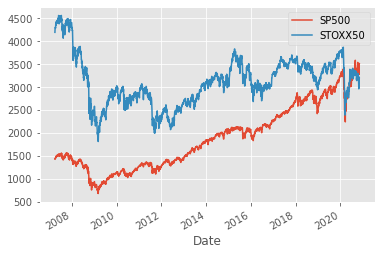

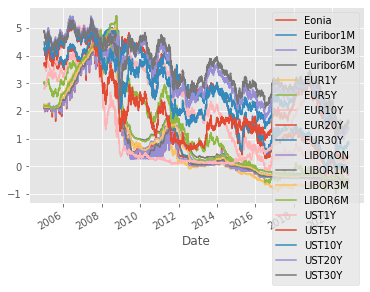

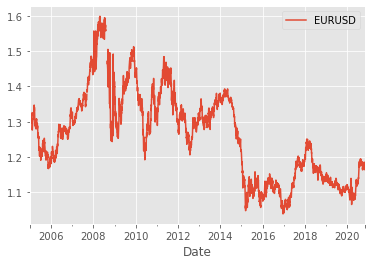

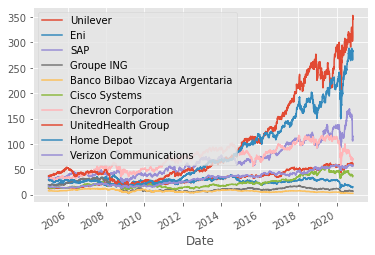

In [4]:
Actions.plot()
Taux.plot()
Echanges.plot()
Stocks.plot()

Afin de pouvoir étudier un panel important de données, et notamment des taux, nous importons ici un grand nombre de fichier.
Dans un premier temps, toutes les données importées ne seront pas utilisées.
Dans les 6 prochains chapitres, nous ne nous interesserons qu'aux deux indices STOXX50 et S&P500.

Ci-dessous, un schéma récapitulatif des données aggrégées : 

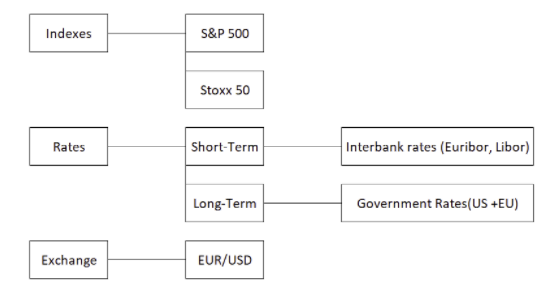

In [186]:
#This function calculates the absolute median deviation of a distribution function.
def Median_Abs_dev(data):    
    mads =[]
    for col in data.columns:
        series = data[col]
        mads.append(series.mad())
    return(mads)
    
#This function calculates the skewness value of a distribution function    
def skewness(data):    
    skews =[]
    for col in data.columns:
        series = data[col]
        skews.append(series.skew())
    return(skews)

#This function calculates the kurtosis value of a distribution function
def kurtosis(data):
    kurtos =[]
    for col in data.columns:
        series = data[col]
        kurtos.append(series.kurt())
    return(kurtos)
    
    
#  ! WARNING ! -> This function calculates the Z-Score of one distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def Z_score(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col]
            stat_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)        

    
#  ! WARNING ! -> This function calculates the t-Score of two distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def t_score(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        
        else:
            series = data[col]
            stat_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)     

    
#  ! WARNING ! -> This function calculates the F-test of two distributions
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def F_test(data, percentage_test):
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col]
            stat_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)     

    
#  ! WARNING ! -> This function calculates the Wilcoxon Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def Wilcoxon(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col] 
            stat_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)     


#  ! WARNING ! -> This function calculates the Mann_Whitneyu Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def Mann_Whitneyu(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col]
            stat_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)     


#  ! WARNING ! -> This function calculates the Hellinger distance between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def Wasserstein(data) :
    res = []
    for col in data.columns:
        series = data[col]
        res.append(wasserstein_distance(data['Testing Set'], data[col]))
    return(res)


### <u> Important </u> : Définition de la classe "Series"  <a class="anchor" id="chapter0.important"></a>

In [205]:
class Series:
    
    def __init__(self, name, values, type_serie):
        self.name = name # nom de la série
        self.values = values # dataframe des valeurs
        self.type_serie = type_serie
    
    # Fonction qui plot les données
    def visualization(self):
        plt.plot(self.values)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Evolution of ' + self.name)
    
    # Fonction qui plot et retourne le tableau des valeurs des rendements
    def returns(self):
        if self.type_serie == "Action":
            var_pct = self.values.pct_change().dropna()
            rdmt = np.log(1 + var_pct)
        if self.type_serie == "Taux":
            rdmt = self.values.diff().dropna()
        plt.plot(rdmt)
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.title('Daily Logarithmic Returns for ' + self.name)
        return(rdmt)
    
    # Fonction qui renvoie la partie "training" du dataset
    def split_data(self):
        ret = self.returns()
        plt.close()
        T = ceil(len(ret.index)*0.8)
        train = ret[:T]     
        test = ret[T:]
        return(train, test)
    
 
    # Fonction qui utilise la méthode HS (simple bootstrap) pour prédire les rendements/prix
    def historical_simulation(self,nb_paths):
        training_data, testing_data  = self.split_data()
        depart = float(self.values.iloc[len(training_data)-1])
        
        # Boostrapping
        random.seed(43)
        bootstrapped_returns = pd.DataFrame([random.choices(list(training_data.iloc[:,0]), k=len(testing_data)) for i in range(nb_paths)]).T
        bootstrapped_returns.index = testing_data.index
        
        res = bootstrapped_returns
        #Graphique 1
        bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements bootstrappés, nombre de chemins = '+str(nb_paths))
        bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        #Graphique 2
        data=self.values
        bootstrapped_prices = (1+bootstrapped_returns).shift(1).fillna(depart).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        if self.type_serie == "Action":
            plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        if self.type_serie == "Taux":
            plt.title('Scénarios de taux interet, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')

        return(res)
    
    
    ## Fonction qui utilise la méthode FHS (bootstrapping sur rendements standardisés, avec fenêtre glissante pour le calcul de la vol.) pour prédire les rendements/prix    
    def filtered_historical_simulation_glissant(self,nb_paths,len_fenetre):          
        
        training_data, testing_data = self.split_data()
        depart = float(self.values.iloc[len(training_data)])
        
        ######## Filtration - Fenetre glissante ########
        vol = []
        for i in range(len_fenetre,len(training_data)):
            vol.append(np.std(training_data[self.name][i-len_fenetre:i]))
        vol2 = [vol[0] for i in range(0, len_fenetre)]
        vol2.extend(vol)
        vol2 = pd.DataFrame(vol2, columns = ['vol'])
        vol2.index = training_data.index
        vol2['rdt_std'] = training_data[self.name]/vol2['vol']
        vol2[self.name] = training_data[self.name]
        
        init_copy_vol2 = vol2
        ######## Boostrapping - 'Nb_paths' scénarios de longueur 'Testing_data' ########
        filtred_bootstrapped_returns = pd.DataFrame([random.choices(list(vol2['rdt_std']), k=len(testing_data)) for i in range(nb_paths)]).T
        
        res = pd.DataFrame([])
        for i in range(0,nb_paths):
            vol2 = init_copy_vol2
            for j in range(0,len(testing_data)):
                vol = vol2['vol'].iloc[-1]                        #Voir excel 
                rdtstd = filtred_bootstrapped_returns[i][j]               #Voir excel
                stoxx = vol * rdtstd                              #Voir excel
                list_rdt = list(vol2[self.name][-len_fenetre-1:]) #Sliding window de 20, on prend les 19 dernières valeurs +
                list_rdt.append(stoxx)                            #la 20ème valeur
                vol = np.std(list_rdt)
                add = pd.DataFrame([[vol, rdtstd, stoxx]])        #Mise en forme des données générés
                
                ## Ajout au dataframe calculé dans la partie 1
                add.columns = vol2.columns                        
                vol2 = vol2.append(add)
            
            ## Ajout du scenario FHS généré dans le fichier de sauvegarde
            idx = str(i)
            res[idx] = vol2[self.name][-len(testing_data):]
        
        ## Mise en forme de l'ensemble des scénari FHS générés
        res.index = testing_data.index
        filtred_bootstrapped_returns = res
            
        ##Graphique 1
        filtred_bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements bootstrappés, nombre de chemins = '+str(nb_paths))
        filtred_bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        filtred_bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        filtred_bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        #Graphique 2
        data=self.values
        bootstrapped_prices = (1+filtred_bootstrapped_returns).shift(1).fillna(depart).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        if self.type_serie == "Action":
            plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        if self.type_serie == "Taux":
            plt.title('Scénarios de taux interet, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')
        
        return(filtred_bootstrapped_returns)
    
#     ##This function calculates the absolute median deviation of a distribution function.
#     def Median_Abs_dev(data):    
#         mads =[]
#         for col in data.columns:
#             series = data[col]
#             mads.append(series.mad())
#         return(mads)
    
#     #This function calculates the skewness value of a distribution function.
#     def skewness(data):    
#         skews =[]
#         for col in data.columns:
#             series = data[col]
#             skews.append(series.skew())
#         return(skews)

#     #This function calculates the kurtosis value of a distribution function
#     def kurtosis(data):
#         kurtos =[]
#         for col in data.columns:
#             series = data[col]
#             kurtos.append(series.kurt())
#         return(kurtos)
    
    
#     #  ! WARNING ! -> This function calculates the Z-Score of one distribution.
#     # The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
#     def Z_score(data, percentage_test) :
#         stat_val = []
#         res_p_val = []
#         res_pct_test = []
#         for col in data.columns:
#             if col == 'Testing Set':
#                 stat_val.append('NaN')
#                 res_p_val.append('NaN')
#             else:
#                 series = data[col]
#                 stat_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[0])
#                 res_p_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1])
        
#         for i in range(len(res_p_val)): 
#             if float(res_p_val[i]) >= float(percentage_test):
#                 res_pct_test.append(1)
#             else: 
#                 res_pct_test.append(0)
                
#         return (stat_val, res_pct_test)

    
#     #  ! WARNING ! -> This function calculates the t-Score of two distribution.
#     # The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
#     def t_score(data) :
#         stat_val = []
#         res_p_val = []
#         for col in data.columns:
#             if col == 'Testing Set':
#                 stat_val.append('NaN')
#                 res_p_val.append('NaN')
#             else:
#                 series = data[col]
#                 stat_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[0])
#                 res_p_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[1])
#         return (stat_val, res_p_val)

    
#     #  ! WARNING ! -> This function calculates the F-test of two distributions
#     # The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
#     def F_test(data):
#         stat_val = []
#         res_p_val = []
#         for col in data.columns:
#             if col == 'Testing Set':
#                 stat_val.append('NaN')
#                 res_p_val.append('NaN')
#             else:
#                 series = data[col]
#                 stat_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[0])
#                 res_p_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[1])
#         return (stat_val, res_p_val)

    
#     #  ! WARNING ! -> This function calculates the Wilcoxon Test between two distributions.
#     # The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
#     def Wilcoxon(data) :
#         stat_val = []
#         res_p_val = []
#         for col in data.columns:
#             if col == 'Testing Set':
#                 stat_val.append('NaN')
#                 res_p_val.append('NaN')
#             else:
#                 series = data[col]
#                 stat_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[0])
#                 res_p_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[1])
#         return (stat_val, res_p_val)


#     #  ! WARNING ! -> This function calculates the Mann_Whitneyu Test between two distributions.
#     # The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
#     def Mann_Whitneyu(data) :
#         stat_val = []
#         res_p_val = []
#         for col in data.columns:
#             if col == 'Testing Set':
#                 stat_val.append('NaN')
#                 res_p_val.append('NaN')
#             else:
#                 series = data[col]
#                 stat_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[0])
#                 res_p_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[1])
#         return (stat_val, res_p_val)


#     #  ! WARNING ! -> This function calculates the Hellinger distance between two distributions.
#     # The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
#     def Wasserstein(data) :
#         res = []
#         for col in data.columns:
#             series = data[col]
#             res.append(wasserstein_distance(data['Testing Set'], data[col]))
#         return(res)

    # Fonction qui compare les résultats de nos différentes méthodes
    def describe(self, nb_paths, len_fenetre, percentage_test):
        
        ##On recup les DataFrame de 667x500 issus de HS & FHS
        simulated_data_HS = self.historical_simulation(nb_paths)
        plt.close()
        simulated_data_FHS_glissant = self.filtered_historical_simulation_glissant(nb_paths, len_fenetre)
        plt.close()
        training_data, testing_data = self.split_data()
        plt.close()
        plt.clf()
               
        #################################################################################################
        ################# Réalisation du DataFrame Describe des 1000 scénarios HS #######################
        #################################################################################################        
        
        ## On prépare le DataFrame 
        Data_hs = pd.DataFrame({'Testing Set' : list(testing_data.iloc[:,0])}, index=testing_data.index)
        Data_hs = pd.concat([Data_hs, simulated_data_HS], axis = 1)
        
        ## Première opération classique ne necessitant pas de comparaison 
        res_hs = Data_hs.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
        res_hs.loc['Median Absolute Deviation'] = Median_Abs_dev(Data_hs) #Add MAD measurement to the recap table
        res_hs.loc['skew'] = skewness(Data_hs)                                   #Add skew measurement to the recap table
        res_hs.loc['kurtosis'] = kurtosis(Data_hs)                               #Add kurtosis measurement to the recap table
        
        ## Marche uniquement si notre Dataframe à 2 indices ou plus
        if len(Data_hs.columns) > 1 : 
            res_hs.loc['Wasserstein Distance'] = Wasserstein(Data_hs)
            res_hs.loc['Wilcoxon Test'] = Wilcoxon(Data_hs, percentage_test)[0]
            res_hs.loc['Wilcoxon H0 % Acceptance'] = Wilcoxon(Data_hs, percentage_test)[1]
            res_hs.loc['Mann-Whitneyu Test'] = Mann_Whitneyu(Data_hs, percentage_test)[0]
            res_hs.loc['Mann-Whitneyu H0 % Acceptance'] = Mann_Whitneyu(Data_hs, percentage_test)[1]
            res_hs.loc['F_test'] = F_test(Data_hs, percentage_test)[0]
            res_hs.loc['F_test H0 % Acceptance'] = F_test(Data_hs, percentage_test)[1]
            res_hs.loc['t_test'] = t_score(Data_hs, percentage_test)[0]
            res_hs.loc['t_test H0 % Acceptance'] = t_score(Data_hs, percentage_test)[1] 
            res_hs.loc['Z_test'] = Z_score(Data_hs, percentage_test)[0]
            res_hs.loc['Z_test H0 % Acceptance'] = Z_score(Data_hs, percentage_test)[1]
        
        #################################################################################################
        ################ Réalisation du DataFrame Describe des 1000 scénarios FHS #######################
        #################################################################################################
        Data_fhs = pd.DataFrame({'Testing Set' : list(testing_data.iloc[:,0])}, index=testing_data.index)
        Data_fhs = pd.concat([Data_fhs, simulated_data_FHS_glissant], axis = 1)
        
        ## Première opération classique ne necessitant pas de comparaison 
        res_fhs = Data_fhs.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
        res_fhs.loc['Median Absolute Deviation'] = Median_Abs_dev(Data_fhs) #Add MAD measurement to the recap table
        res_fhs.loc['skew'] = skewness(Data_fhs)                                   #Add skew measurement to the recap table
        res_fhs.loc['kurtosis'] = kurtosis(Data_fhs)                               #Add kurtosis measurement to the recap table
        
        ## Marche uniquement si notre Dataframe à 2 indices ou plus
        if len(Data_fhs.columns) > 1 : 
            res_fhs.loc['Wasserstein Distance'] = Wasserstein(Data_fhs)
            res_fhs.loc['Wilcoxon Test'] = Wilcoxon(Data_fhs, percentage_test)[0]
            res_fhs.loc['Wilcoxon H0 % Acceptance'] = Wilcoxon(Data_fhs, percentage_test)[1]
            res_fhs.loc['Mann-Whitneyu Test'] = Mann_Whitneyu(Data_fhs, percentage_test)[0]
            res_fhs.loc['Mann-Whitneyu H0 % Acceptance'] = Mann_Whitneyu(Data_fhs, percentage_test)[1]
            res_fhs.loc['F_test'] = F_test(Data_fhs, percentage_test)[0]
            res_fhs.loc['F_test H0 % Acceptance'] = F_test(Data_fhs, percentage_test)[1]
            res_fhs.loc['t_test'] = t_score(Data_fhs, percentage_test)[0]
            res_fhs.loc['t_test H0 % Acceptance'] = t_score(Data_fhs, percentage_test)[1] 
            res_fhs.loc['Z_test'] = Z_score(Data_fhs, percentage_test)[0]
            res_fhs.loc['Z_test H0 % Acceptance'] = Z_score(Data_fhs, percentage_test)[1]
        
        
        #################################################################################################
        ####### Réalisation Tableau Describe à partir des describe de chaque scénario généré ############
        #################################################################################################        
        
        ## On prépaer notre tableau final
        res = pd.DataFrame({'Testing Set' : list(res_hs['Testing Set'])}, index=res_hs.index)
        
        ## On supprime les columns Testing Set de nos tableaux HS & FHS pour pouvoir réaliser nos comparaisons
        res_hs = res_hs.drop(columns=['Testing Set'])
        res_fhs = res_fhs.drop(columns=['Testing Set'])
        
        ## On prépare les dataframe des moyennes de chacunes des mesures effectuées
        hs_df = pd.DataFrame({'Historical Simulation' : list(res_hs.mean(axis = 1))}, index = res_hs.index)
        fhs_df = pd.DataFrame({'Filtered HS' : list(res_fhs.mean(axis = 1))}, index = res_fhs.index)
        
        ##On prépare le tableau à retourner
        res = pd.concat([res, hs_df, fhs_df], axis=1)
        
        # On découpe le tableau en deux parties - Mesures statistiques / Tests Statistiques
        mesure = pd.DataFrame(res.iloc[[i for i in range (11)]])
        
        test = res.drop(columns=['Testing Set'])
        test = pd.DataFrame(test.iloc[[i for i in range (11,22)]])
        
        #On rajoute un titre pour chaque dataframe
        mesure = mesure.style.set_caption('Mesure statistiques  ' + self.name + ', Nombre de chemin =' + str(nb_paths) + ', Longueur Fenetre = ' + str(len_fenetre))
        test = test.style.set_caption('Tests statistiques  ' + self.name+ ', Nombre de chemin =' + str(nb_paths) + ', Longueur Fenetre = ' + str(len_fenetre) + ', Seuil H0 Test Statistique = ' + str((1-percentage_test)*100) + ' %')
        
        return mesure, test

Commençons par choisir une série de données à étudier.

In [206]:
serie = Series("Euribor3M", Taux[['Euribor3M']], "Taux")

In [207]:
describe = serie.describe(10,100, 0.20)

<Figure size 432x288 with 0 Axes>

In [208]:
describe_mesure = describe[0]
describe_mesure

,Testing Set,Historical Simulation,Filtered HS
count,810.000000,810.000000,810.000000
mean,-0.000226,-0.000898,-0.000048
std,0.006270,0.011252,0.018260
min,-0.031000,-0.091700,-0.192547
25%,-0.001000,-0.001900,-0.001432
50%,0.000000,0.000000,0.000000
75%,0.000000,0.001375,0.001189
max,0.061000,0.086700,0.191872
Median Absolute Deviation,0.002874,0.005107,0.006756
skew,1.931947,-1.451714,0.941837


In [209]:
describe_test = describe[1]
describe_test

,Historical Simulation,Filtered HS
Wasserstein Distance,0.002208,0.005148
Wilcoxon Test,127767.400000,128158.950000
Wilcoxon H0 % Acceptance,0.300000,0.900000
Mann-Whitneyu Test,321295.850000,317544.400000
Mann-Whitneyu H0 % Acceptance,0.300000,0.900000
F_test,2.790902,0.623167
F_test H0 % Acceptance,0.300000,0.900000
t_test,1.481025,-0.449084
t_test H0 % Acceptance,0.300000,0.900000
Z_test,1.481025,-0.449084


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-31,0.001,0.000,0.000,-0.045,-0.004,-0.011,-0.005,0.000,0.002,0.000,...,0.004,0.008,0.002,-0.005,0.001,-0.001,0.002,-0.001,0.000,0.001
2017-09-01,0.000,0.001,0.003,-0.001,-0.057,-0.002,0.000,0.000,0.000,-0.008,...,0.000,0.006,0.000,-0.003,0.003,0.001,0.001,-0.005,0.001,0.000
2017-09-04,0.010,-0.002,-0.001,-0.004,-0.004,0.001,0.001,0.008,0.000,-0.001,...,-0.003,-0.014,0.032,-0.001,0.003,-0.001,-0.006,-0.001,0.000,-0.003
2017-09-05,-0.001,-0.009,0.001,-0.003,0.000,-0.002,0.005,0.000,0.000,0.049,...,0.002,-0.005,0.010,-0.001,0.001,0.008,-0.005,-0.014,0.000,0.001
2017-09-06,0.001,0.000,-0.002,-0.004,-0.001,0.003,-0.001,-0.001,0.000,0.005,...,-0.002,0.000,-0.001,0.005,0.000,-0.002,-0.001,0.001,-0.001,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,0.005,-0.001,0.001,0.000,0.002,0.000,0.018,-0.004,-0.005,-0.001,...,-0.001,-0.003,-0.001,-0.001,0.000,-0.008,0.001,0.006,0.003,0.000
2020-11-03,-0.007,-0.006,0.001,-0.001,-0.008,0.000,0.000,0.004,0.005,0.000,...,0.000,0.000,-0.008,0.001,0.007,-0.020,0.001,0.007,-0.001,0.002
2020-11-04,0.000,-0.002,-0.001,-0.008,-0.006,-0.007,0.002,0.015,0.001,-0.001,...,-0.002,-0.001,-0.002,0.000,-0.008,-0.001,0.000,-0.001,0.001,0.001


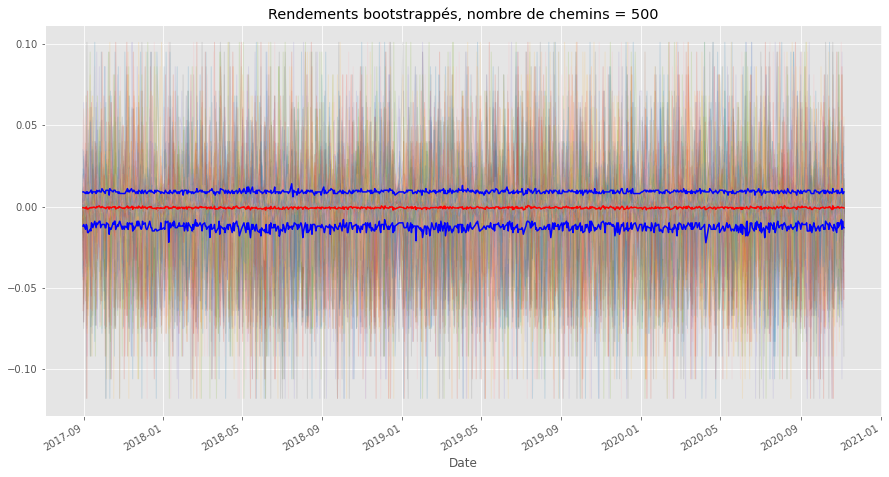

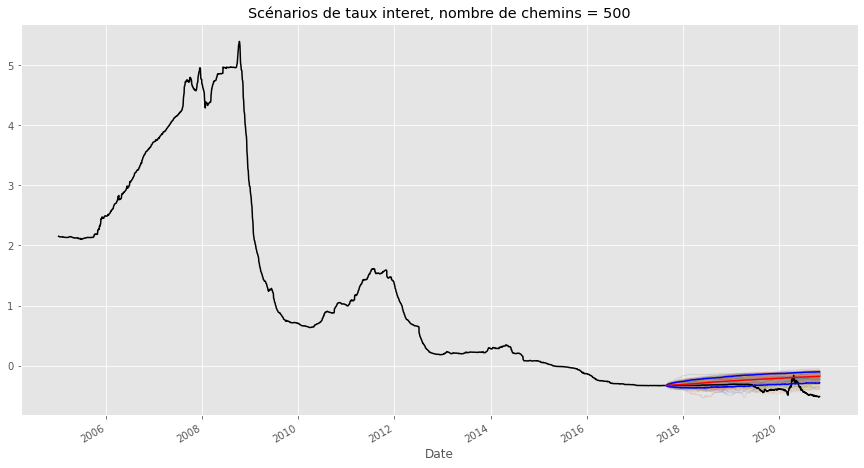

In [100]:
serie.historical_simulation(500)


In [15]:
serie2 = Series("Unilever", Stocks[['Unilever']], "Action")
serie2.describe(1000,100)

,Testing Set,Historical Simulation,Filtered HS
count,798,798.000000,798.000000
mean,0.000177372,0.000436,0.000364
std,0.0144336,0.014107,0.009611
min,-0.102541,-0.083221,-0.049866
25%,-0.00551856,-0.006382,-0.004493
50%,0.000569273,0.000811,0.000597
75%,0.00710444,0.007454,0.005283
max,0.110712,0.082263,0.052741
Median Absolute Deviation,0.00931851,0.009800,0.006801
skew,-0.648776,-0.148312,-0.014241


<Figure size 432x288 with 0 Axes>

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-08,0.001170,0.047324,0.012605,0.031077,0.018224,0.004284,0.023416,0.019315,-0.001475,0.005819,...,-0.015951,0.011888,-0.003255,0.009872,0.002211,0.004540,0.009648,-0.018162,0.017122,-0.014441
2017-09-11,0.015873,-0.007842,0.035464,-0.007456,0.012636,-0.001499,-0.005104,-0.006194,0.003305,-0.009432,...,0.018175,-0.007343,0.008277,-0.004005,0.024636,-0.003030,0.001096,-0.003930,-0.007900,0.008243
2017-09-12,-0.002661,0.002308,-0.023872,-0.001145,-0.015483,0.026023,0.021633,0.012398,0.019196,-0.010657,...,-0.044766,-0.021138,0.004141,-0.005965,0.006643,-0.000756,-0.028771,-0.012370,0.000577,0.001039
2017-09-13,-0.020874,0.002438,-0.026832,0.004149,0.026476,0.002211,-0.012848,-0.014319,0.017180,-0.026534,...,-0.013949,-0.016104,-0.014987,0.001792,-0.002981,-0.019992,-0.007186,0.025864,-0.019423,-0.016210
2017-09-14,0.025183,-0.003721,-0.006190,-0.022878,0.020170,-0.028828,0.008757,-0.004692,0.014360,-0.001122,...,0.022258,0.003424,0.022258,0.012943,-0.002216,0.003754,0.003281,-0.040310,-0.018405,-0.000201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,-0.002553,-0.019184,-0.038333,-0.012262,0.016078,0.004440,0.001860,0.007934,0.010169,0.012724,...,0.007934,-0.037762,-0.004998,0.001780,-0.005205,-0.050749,0.017262,-0.011644,0.001911,0.013967
2020-11-03,-0.012878,0.032644,-0.023150,0.006676,-0.013417,0.013496,-0.008089,0.007231,-0.015816,0.009101,...,-0.002484,0.017239,-0.001939,0.015873,-0.017970,-0.005939,0.000432,-0.024200,-0.002022,0.003623
2020-11-04,0.000212,-0.006161,-0.009805,0.002060,0.017262,0.000342,-0.001954,0.005251,0.013241,0.014554,...,0.011939,0.000210,-0.007914,-0.015244,0.012428,-0.045810,-0.006835,0.000664,-0.014854,0.006038


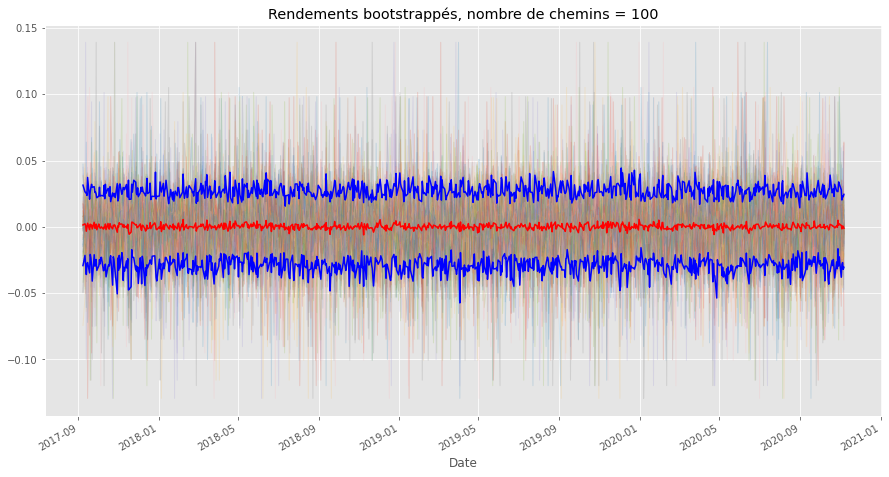

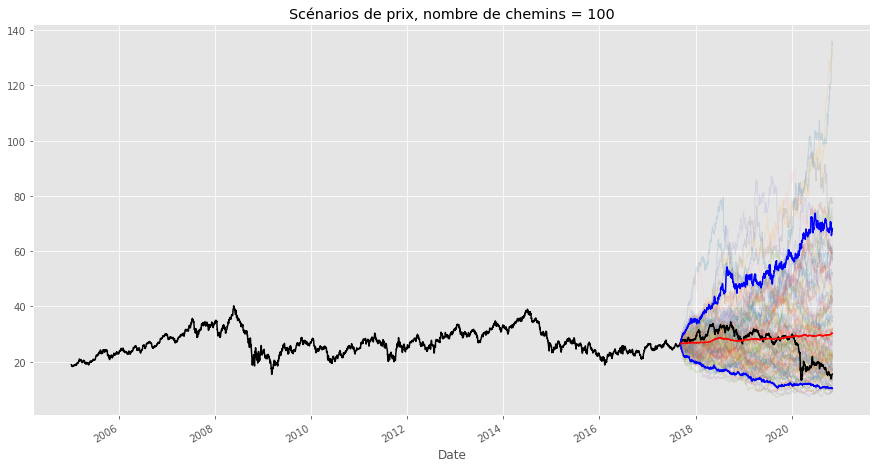

In [18]:
serie2.historical_simulation(100)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-08,-0.003985,-0.016716,-0.004017,0.001195,0.002540,-0.000703,0.007927,0.029709,-0.006120,-0.002111,...,-0.007213,-0.004936,-0.006604,-0.014828,-0.008108,0.015315,-0.008980,-0.001964,0.013563,-0.000120
2017-09-11,0.003272,-0.002374,0.016928,0.000069,-0.025822,-0.003519,-0.020609,-0.001186,-0.002756,0.008049,...,0.003469,-0.016286,-0.006768,0.001586,-0.005453,-0.005624,-0.011128,0.000643,-0.011425,-0.002371
2017-09-12,0.006277,-0.010962,0.012377,0.005247,-0.013672,-0.018225,-0.007644,0.006262,0.002874,0.018595,...,0.005789,0.012303,-0.013257,-0.027457,0.008359,0.000000,-0.011204,0.001881,-0.002962,0.005714
2017-09-13,0.004686,0.001720,0.000875,0.019900,0.004598,0.005802,0.005276,0.010227,0.007065,0.008094,...,-0.009263,0.006857,-0.005276,0.004402,-0.000373,0.002310,-0.009471,0.003448,-0.030412,-0.006599
2017-09-14,-0.002413,-0.004031,0.003375,0.001494,-0.014605,0.012461,0.009026,-0.000257,0.005326,-0.016921,...,-0.012431,0.027149,-0.004598,0.003820,0.014942,-0.009289,0.004113,-0.003756,-0.002727,0.003324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,-0.018570,0.001422,-0.011993,0.003596,0.000391,0.014142,0.015944,0.004164,-0.003700,-0.079047,...,0.006867,0.003438,0.038315,-0.034150,0.023041,-0.034498,0.010546,0.001168,-0.006692,0.032849
2020-11-03,-0.022400,-0.007550,0.001723,0.010860,0.012827,-0.007533,0.008046,-0.002964,-0.000883,0.012625,...,0.005559,-0.006220,-0.004090,0.011687,-0.079767,-0.030163,0.002315,0.006611,0.007178,-0.003817
2020-11-04,-0.022190,-0.022849,-0.012929,-0.002508,-0.013217,0.001529,-0.005474,0.012232,-0.007594,0.003499,...,-0.000429,-0.003929,0.000000,-0.056788,-0.003504,0.001557,-0.002977,0.002690,-0.008158,-0.007800


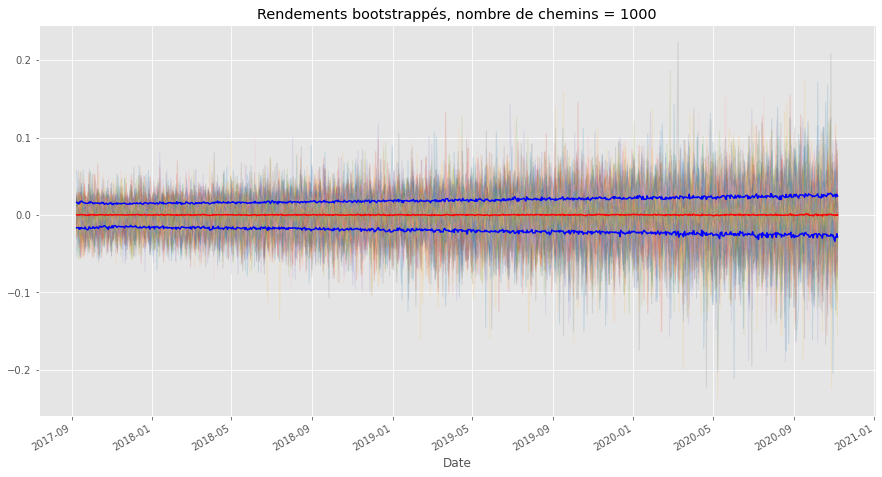

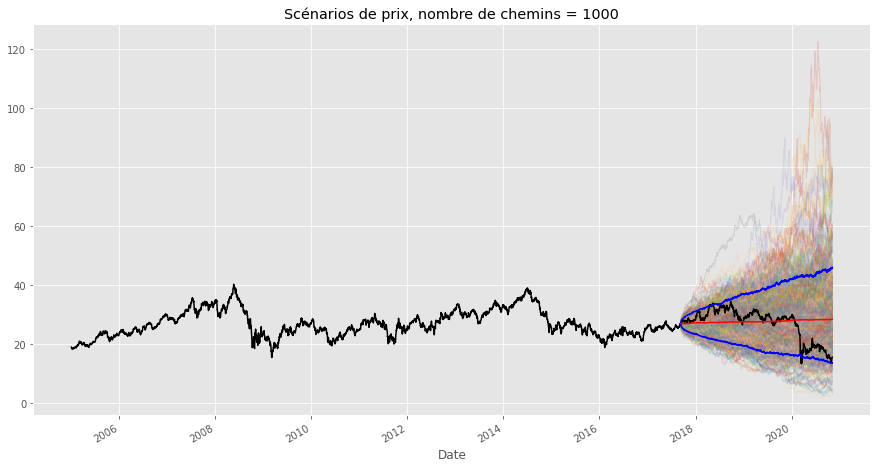

In [19]:
serie2.filtered_historical_simulation_glissant(1000,100)

In [20]:
serie3 = Series("Eni", Stocks[['Eni']], "Action")
serie3.describe(1000,100)

,Testing Set,Historical Simulation,Filtered HS
count,798,798.000000,798.000000
mean,-0.000688414,0.000085,0.000085
std,0.0217457,0.019332,0.012538
min,-0.246317,-0.107705,-0.062176
25%,-0.00835006,-0.009101,-0.006613
50%,0.000314935,0.000956,0.000657
75%,0.008139,0.010177,0.007325
max,0.126812,0.105766,0.054260
Median Absolute Deviation,0.0129687,0.013493,0.009218
skew,-2.61134,-0.249942,-0.330214


<Figure size 432x288 with 0 Axes>

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-08,-0.010659,0.012110,-0.004795,0.001443,-0.004148,-0.002393,0.018536,0.001884,-0.016314,0.009760,...,-0.001429,-0.007555,0.021258,0.008407,0.006373,-0.009726,-0.002487,-0.003625,-0.002084,-0.002833
2017-09-11,0.008030,-0.025510,-0.009669,0.004657,0.000799,0.001641,-0.015373,0.006052,-0.008639,-0.005413,...,0.000755,-0.001492,0.001235,-0.009745,-0.002049,0.014815,-0.007413,0.009392,0.005935,0.000928
2017-09-12,0.001582,0.003373,0.024462,-0.001294,0.023511,-0.002143,0.008049,0.009227,-0.015347,-0.009242,...,-0.009706,-0.002002,-0.003316,0.006767,0.015574,-0.009112,0.009669,-0.009938,-0.002974,-0.024649
2017-09-13,-0.009759,-0.005357,0.008110,0.002310,0.019207,-0.006934,0.002512,-0.002424,0.006739,-0.009914,...,-0.002217,0.015235,-0.033269,0.000117,-0.001494,0.001210,-0.002387,0.001551,-0.003445,0.004241
2017-09-14,0.005103,-0.001460,-0.013058,0.001569,0.003554,0.001279,0.010273,0.002117,-0.004903,-0.009284,...,0.003582,-0.007451,-0.005646,-0.004787,-0.000728,-0.004940,-0.007987,0.010508,-0.005313,0.006533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,0.003479,-0.004726,0.042443,-0.011601,0.004941,0.004181,0.002115,-0.006362,0.007013,0.004972,...,0.001154,-0.004801,-0.021446,-0.035897,0.023124,0.013483,-0.005998,0.004459,-0.024479,0.011260
2020-11-03,-0.002172,-0.015112,-0.004154,-0.001460,0.003024,-0.000563,0.006503,0.000818,-0.025213,-0.008739,...,0.025741,-0.009287,0.009446,0.006500,-0.014404,-0.015049,-0.002469,-0.011594,0.001254,0.000228
2020-11-04,-0.005312,0.021064,0.025094,0.007145,0.010137,0.002935,0.008941,0.001705,0.013856,-0.001660,...,0.011492,-0.001687,-0.024293,0.038231,-0.067711,-0.002786,-0.000617,-0.015286,-0.007703,0.002017


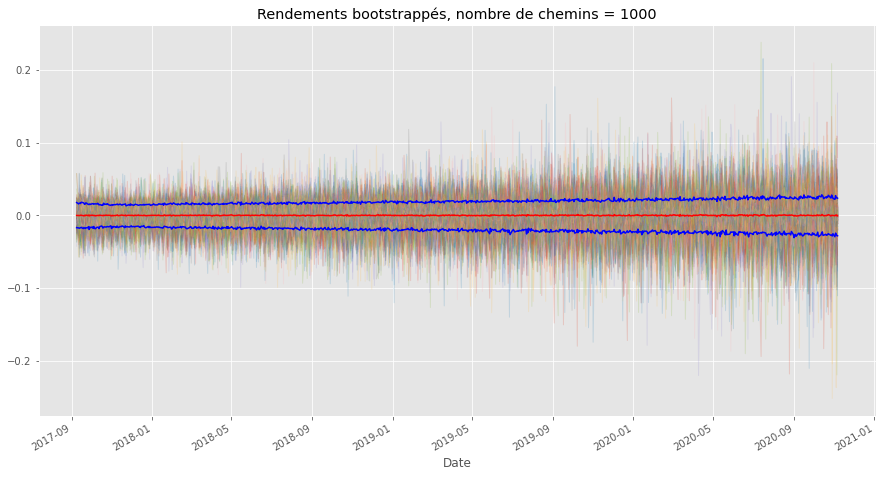

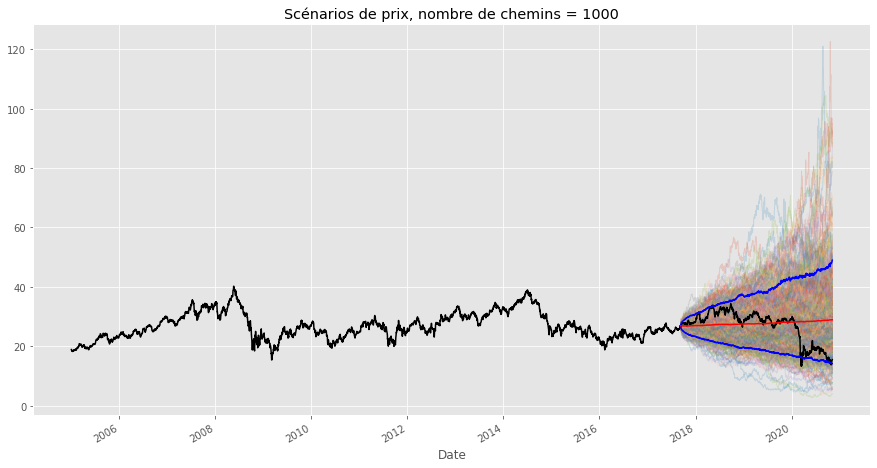

In [21]:
serie3.filtered_historical_simulation_glissant(1000,100)

On peut maintenant afficher le rendement logarithmique journalier de notre série.

## I - Préparation de notre data set pour la simulation <a class="anchor" id="chapter1"></a>

[Retour Sommaire](#sommaire)

#### I.1 - Conversion des données en rendements logarithmiques <a class="anchor" id="chapter1.1"></a>


,STOXX50
Date,
2007-04-03,0.013455
2007-04-04,0.003651
2007-04-05,0.002276
2007-04-10,0.006982
2007-04-11,-0.001924
...,...
2020-11-02,0.020520
2020-11-03,0.025885
2020-11-04,0.019921


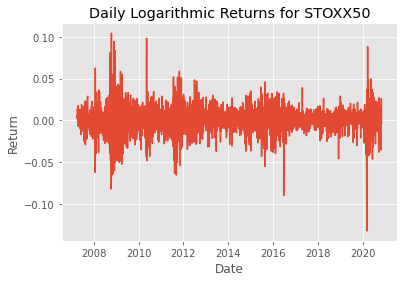

In [13]:
serie.returns()

<u>Remarque:</u> On voit bien les fortes variations en 2009 (crise financière) et idem en début 2020 (crise du COVID-19)

#### I.2 - Split de notre dataset <a class="anchor" id="chapter1.2"></a>

[Retour Sommaire](#sommaire)

On sépare ensuite notre data set en deux.

- La première partie (80%) correspond au Training Set
- La seconde partie (20%) correspond au Testing Set

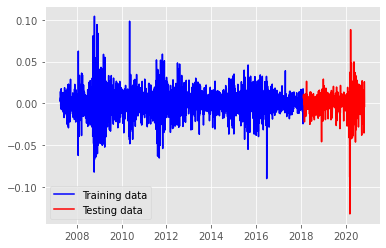

In [14]:
training_data, testing_data = serie.split_data()
plt.plot(training_data,c='b',label='Training data')
plt.plot(testing_data,c='r',label='Testing data')
plt.legend()

## II - Modélisation paramétrique <a class="anchor" id="chapter2"></a>

[Retour Sommaire](#sommaire)

Nous avons voulu dans un premier temps réaliser une méthode simple de modélisation et de prédiction. L'objectif était tout d'abord de manipuler nos set de données, mais aussi d'apprécier la performance de ce type de méthode afin de les comparer avec les méthodes plus complexes que nous étudierons par la suite.

#### II.1 - Modèle GARCH(p,q)  <a class="anchor" id="chapter2.section1"></a>

Pour trouver le modèle le plus adapté à notre série temporelle, nous allons utiliser une fonction de performance et nous allons déterminer les paramètres p et q optimaux pour notre modèle GARCH(p,q).

On rappelle le format général d'un modèle GARCH(p,q): 
$$ \sigma^{2}_{t} = \omega + \sum_{j=1}^{q}\alpha_{j}\epsilon^{2}_{t-j}  +  \sum_{j=1}^{p}\beta_{j}\sigma^{2}_{t-j}  $$

Par exemple, si p=q=1, cela signifie que :

$$ r_{t} = \mu + \epsilon_{t} $$

$$ \sigma^{2}_{t} = \omega + \alpha \epsilon^{2}_{t-1} + \beta \sigma^{2}_{t-1} $$

$$ \epsilon_{t} = \sigma_{t}e_{t} $$ 
with $ e_{t}\sim N(0,1) $

In [ ]:
# best_pq , model_garch = serie.garch(5,5)
# model_garch.summary()

#### II.2 - Simulations grâce à notre modèle GARCH (p,q)  <a class="anchor" id="chapter2.section2"></a>

In [ ]:
# serie.garch_modelisation(5,5)

Les résultats ne semblent pas concluant avec ce modèle, il ne peut pas être utilisé pour la suite.

Dans un prochain chapitre, nous reviendrons sur ces prédictions et nous réaliserons une comparaison plus poussée, notamment par rapport aux valeurs réelles, grâce à différentes mesures. Nous comparerons aussi leur performance par rapport au modèle que nous allons décrire dans le prochain chapitre, le boostrapping.

## III- Bootstrapping <a class="anchor" id="chapter3"></a>

[Retour Sommaire](#sommaire)

On réalise un bootstrapping sur les rendements de notre série de données. Nous générons pour cela 1000 scénarios issus du réechantillonage de notre Training set.

On calcule sur l'ensemble de nos scénarios générés par bootstrapping : 

- <strong>le quantile à 5% et 95% </strong>
- <strong>le quantile à 95% </strong>
- <strong>la moyenne </strong>

Puis on affiche le graphique comprenant ces trois mesures.

In [ ]:
serie.historical_simulation(1000)

## IV - Filtred Historical Simulation <a class="anchor" id="chapter4"></a>

[Retour Sommaire](#sommaire)

<u><strong> Etape 1 :</strong> Trouver le meilleur modèle de volatilité conditionnel (GARCH) pour le rendement à modéliser </u>

Pour rappel, nous avons défini une fonction <i> best_param_garch </i> en <strong> III.1.1 </strong>. Nous allons nous en servir afin de trouver le meilleur modéle GARCH

<u><strong> Etape 2 : </strong> Standardisation des rendements </u>

<u><strong>Etape 3 :</strong> Bootstrapping à partir des rendements standardisés </u>

In [ ]:
# serie.filtered_historical_simulation_GARCH(1000)

##### Complément : FHS utilisant la fenêtre glissante

In [ ]:
serie.filtered_historical_simulation_glissant(1000,20)

## V - Fonction de performance <a class="anchor" id="chapter5"></a>

[Retour Sommaire](#sommaire)

Nous allons maintenant comparer de façon statistique les performances des scénarios générés. Pour cela, nous avons réalisé une fonction comprenant un certain nombre de mesures permettant de comparer les différents scénarios.

#### V.1 - Fonctions de mesures <a class="anchor" id="chapter5.section1"></a>

Nous avons commencé par définir 3 fonctions simples qui permettent de calculer : 

- la déviation en valeur absolue à la médiane d'une distribution de fonction 
- l'asymétrie d'une distribution de fonction 
- le kurtosis d'une distribution de fonction 

NB: Chacune de ces fonctions est réalisé de telle sorte qu'elles peuvent être appliquées à un dataset comportant un ou plusieurs jeux de distributions.

In [29]:
#This function calculates the absolute median deviation of a distribution function.
def Median_Abs_dev(data):    
    mads =[]
    for col in data.columns:
        series = data[col]
        mads.append(series.mad())
    return(mads)

In [30]:
#This function calculates the skewness value of a distribution function.
def skewness(data):    
    skews =[]
    for col in data.columns:
        series = data[col]
        skews.append(series.skew())
    return(skews)

In [31]:
#This function calculates the kurtosis value of a distribution function
def kurtosis(data):
    kurtos =[]
    for col in data.columns:
        series = data[col]
        kurtos.append(series.kurt())
    return(kurtos)


Nous avons ensuite choisi 3 tests permettant de comparer la <u>moyenne et la variance entre deux distributions</u> de fonctions : 

- <strong> Z-test </strong> : Comparaison de la moyenne des distributions
- <strong> (Student) t-test </strong>: Comparaison de la moyenne des distributions
- <strong> F-test </strong>: Comparaison de la variance des distributions

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant une ou plusieurs méthodes prédictions.

<strong><u> Z-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ Z = \frac{\bar{X} - \mu_{0}}{s} $$

où : 
- $Z$ : Z-test
- $\bar{X}$ : moyenne de l'échantillon
- $\mu_{0} $ : espérance
- $s$ : écart-type


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
- https://en.wikipedia.org/wiki/Z-test

In [32]:
#  ! WARNING ! -> This function calculates the Z-Score of one distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
from statsmodels.stats.weightstats import ztest

def Z_score(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> (Student) t-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ t = \frac{m - \mu_{0}}{s/ \sqrt{n}} $$

où : 
- $t$ : t-test
- $m$ : espérance
- $\mu_{0} $ : valeur théorique
- $s$ : écart-type
- $n$ : taille de l'échantillon


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- https://en.wikipedia.org/wiki/Student%27s_t-test

In [33]:
#  ! WARNING ! -> This function calculates the t-Score of two distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def t_score(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> F-Test  - Comparaison de la variance des distributions </strong></u> 

$$ F = \frac{Explained Variance}{Unexplained Variance} $$

avec :

$$ Explained Variance = \sum_{i = 1}^{K}n_{i} ({\bar {Y}}_{i \cdot} - {\bar {Y}})^{2} / (K - 1) $$
et
$$ Unexplained Variance = \sum_{i = 1}^{K} \sum_{j = 1}^{n_{i}} ({\bar {Y}}_{ij \cdot} - {\bar {Y}}_{i \cdot})^{2} / (N - K) $$

où 
- $ {Y}_{ij} $ est la j-ème observation dans la i-ème sur K groupes
- N : taille globale de l'échantillon 


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
- https://en.wikipedia.org/wiki/F-test

In [34]:
#  ! WARNING ! -> This function calculates the F-test of two distributions
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

from scipy.stats import f_oneway

def F_test(data):
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

Nous avons ensuite choisi 3 mesures permettant de  <u>comparer deux distributions </u> de fonctions : 

- <strong> Test de rang de Mann-Whitneyu </strong>
- <strong> Test de rang de Wilcoxon </strong>
- <strong> Distance de Wasserstein </strong>

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant une ou plusieurs méthodes prédictions.

<strong><u> Test de rang de Mann-Whitneyu  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

La statistique U de Mann-Whitney correspondante est définie comme suit:

$$ U = \sum_{i = 1}^{n} \sum_{j = 1}^{m} S(X_{i}, Y_{j})  $$

avec

$
  S (X, Y) = \left\{
          \begin{array}{ll}
            1 & \qquad \mathrm{si}\quad Y < X \\
            \frac{1}{2} & \qquad \mathrm{si}\quad Y = X \\
            0 & \qquad \mathrm{si}\quad Y > X \\
          \end{array}
        \right.
$


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
- https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [35]:
#  ! WARNING ! -> This function calculates the Mann_Whitneyu Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Mann_Whitneyu(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> Test de rang de Wilcoxon  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

Le test statistique de Wilcoxon est défini comme suit:

$$ W = \sum_{i = 1}^{N_{r}} [sgn(x_{2,i} - x_{1,i}) * R_{i}]$$

avec
- $W$ : test statistique 
- $N_{r}$ : taille de l'échantillon
- $sng$ : signe de la function
- $x_{2,i} - x_{1,i}$ : paires classées correspondantes des deux distributions
- $R_{i}$ : rang i

Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
- https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test

In [36]:
#  ! WARNING ! -> This function calculates the Wilcoxon Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wilcoxon(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)


<strong><u> Distance de Wasserstein </strong></u> 

La première distance de Wasserstein entre les distributions $u$ et $v$ est:


$$ l_{1}(u,v) =  \inf_{\substack{\pi \in \Gamma(u,v)}} \int_{\mathbb{R}x\mathbb{R}} |x - y|d\pi(x,y)$$

Lien : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [37]:
#  ! WARNING ! -> This function calculates the Hellinger distance between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wasserstein(data) :
    res = []
    for col in data.columns:
        series = data[col]
        res.append(wasserstein_distance(data['Testing Set'], data[col]))
    return(res)

#### V.2 - Fonction Describe   <a class="anchor" id="chapter5.section2"></a>

[Retour Sommaire](#sommaire)

Grâce à toutes les fonctions présentées dans la partie précédente, nous avons réalisé une fonction globale qui, pour un unique dataset en entrée (au format DataFrame), retourne un tableau comparatif comportant les éléments suivants : 

- Espérance & Variance 
- Min / Q25% / Médiane / Q75% / Max
- Déviation de la médiane en valeure absolue
- Asymétrie & Kurtosis
- <strong> Z-test </strong> & <strong>t-test</strong> (pour la comparaison de la moyenne)
- <strong>F-test </strong>(pour la comparaison de la variance)
- <strong>Test de rang de Mann-Whitneyu </strong> & <strong> Test de Wilcoxon</strong> (pour comparer le ranking de deux distributions)
- <strong> Mesure de Wasserstein </strong> (pour comparer la distance entre deux distributions)


<u> NB:</u> Cette fonction est réalisée de telle sorte qu'elle peut être appliqué à un dataset comportant un ou plusieurs jeux de distributions. Dans le cas d'un dataset multiple, les distance citées précédement seront toujours calculées en fonction de la première colonne de ce dataset.

<strong><u> Conséquence: </strong></u>  Il faut impérativement placer les valeurs réelles dans la première colonne de notre DataFrame, afin de pouvoir comparer chaque simulation avec les valeurs réelles, et ainsi comparer la performance de chacunes de nos simulations.

Nous testons notre fonction de performance sur le dataframe de prédictions, qui comporte : 

- Nos données réelles
- La moyenne de nos scénarii générés par Historical Simulation
- La moyenne de nos scénarii générés par Filtered Historical Simulation

In [ ]:
serie.describe()

#### V.3 - Comparaison des prévisions GARCH(p,q) / Boostraping / FHS   <a class="anchor" id="chapter5.section2"></a>

[Retour Sommaire](#sommaire)

## VI - Generative Adversarial Network (GAN) <a class="anchor" id="chapter6"></a>

[Retour Sommaire](#sommaire)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Faire le tri avec les imports initiaux 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns